In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
#import swifter
import networkx as nx
from sklearn.cluster import SpectralClustering

import japanize_matplotlib
import matplotlib.pyplot as plt
#plt.rcParams['font.family'] = 'IPAPGothic' #全体のフォントを設定
%matplotlib inline

/usr/local/lib/python3.7/site-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [3]:
import sys
sys.path.append('../')

import src.network_analytics as na

In [4]:
df_raw = pd.read_csv('../data/moreno_crime/out.moreno_crime_crime',
                     sep=' ', skiprows=2, header=None)
df_raw.drop(2, inplace=True, axis=1)
df_raw.columns = ['id_from', 'id_to']
#df = df_raw.sample(frac=0.1, random_state=14)
df = df_raw.copy()
df.shape

(1476, 2)

In [5]:
df.head()

,id_from,id_to
0,1,1
1,1,2
2,1,3
3,1,4
4,2,5


In [6]:
g1, g2 = na.gen_bipartite_network_projection(df
                                             , n1_name='id_from', n2_name='id_to'
                                            )

In [7]:
g2.number_of_nodes()

829

In [8]:
g1.number_of_nodes()

766

In [9]:
from scipy import sparse

### spectral clustering

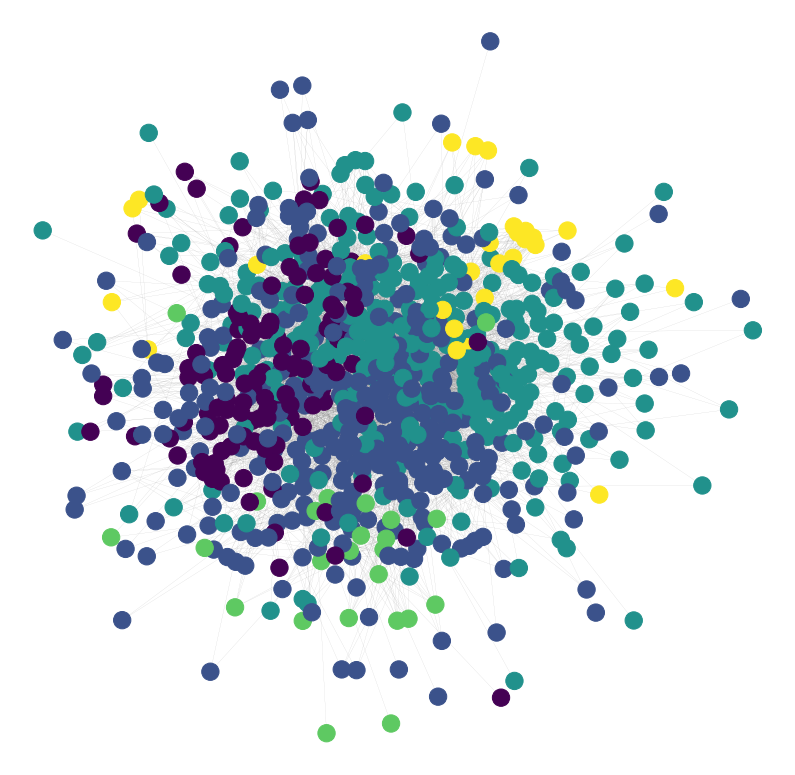

In [10]:
sc = na.sk_spectral_clustering(g2, n=5)
na.draw_network(g2, df, node_color=sc.labels_, draw_label=False)


In [11]:
sc_model = na.SpectralClustering(k=5)
sc_model.fit(g2)
preds = sc_model.predict()
np.unique(preds)

array([0, 1, 2, 3, 4], dtype=int32)

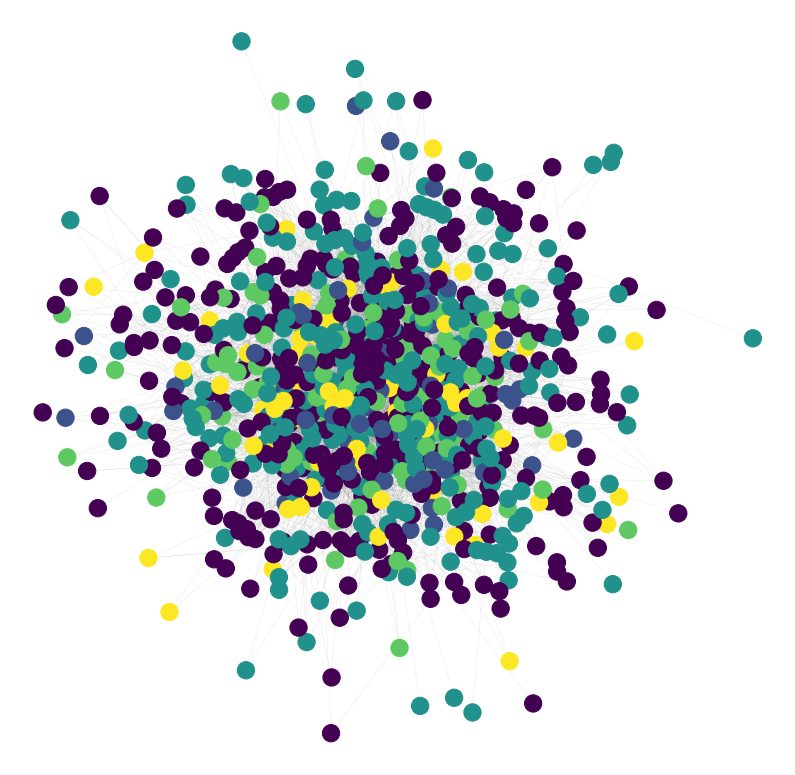

In [12]:
na.draw_network(g2, df, node_color=preds, draw_label=False)


In [13]:
### 最大なクラスターに対して コミュニティ抽出かけてみる

In [14]:
# 孤立したグループの個数
nx.number_connected_components(g2)

1

In [15]:
g2.number_of_nodes()

829

In [16]:
# 任意の条件のグループ(subgraph)を取得
g2_subs = [g2.subgraph(c) for c in nx.connected_components(g2)]
g2_f = [g for g in g2_subs if g.number_of_nodes() >= 10]

In [17]:
[g.number_of_nodes() for g in g2_f]

[829]

In [18]:
sc = na.sk_spectral_clustering(g2_f[0], n=5)


In [19]:
import collections

sc_count = collections.Counter(sc.labels_)
sc_count

Counter({2: 314, 1: 341, 0: 123, 4: 27, 3: 24})

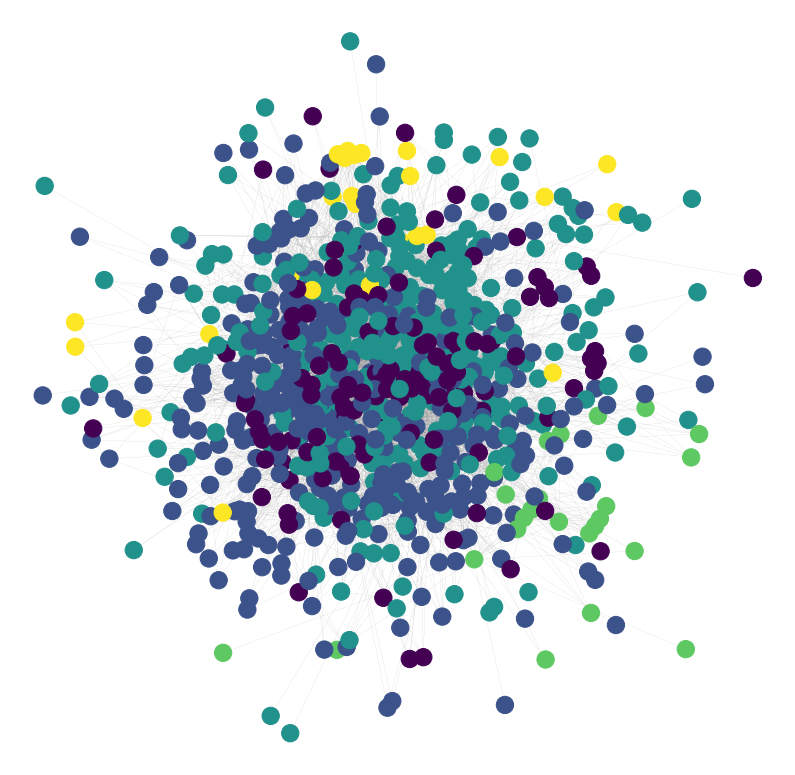

In [20]:
na.draw_network(g2_f[0], df, node_color=sc.labels_, draw_label=False, draw_edge=True)


In [21]:
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy
from scipy.cluster import hierarchy
from scipy.spatial import distance


def create_hc(G):
    """Creates hierarchical cluster of graph G from distance matrix"""
    path_length = nx.all_pairs_shortest_path_length(G)
    distances = numpy.zeros((len(G), len(G)))
    for u, p in path_length:
        for v, d in p.items():
            distances[u][v] = d
    # Create hierarchical cluster
    Y = distance.squareform(distances)
    Z = hierarchy.complete(Y)  # Creates HC using farthest point linkage
    
    # This partition selection is arbitrary, for illustrive purposes
    membership = list(hierarchy.fcluster(Z, t=1.15))
    # Create collection of lists for blockmodel
    partition = defaultdict(list)
    for n, p in zip(list(range(len(G))), membership):
        partition[p].append(n)
    return list(partition.values())


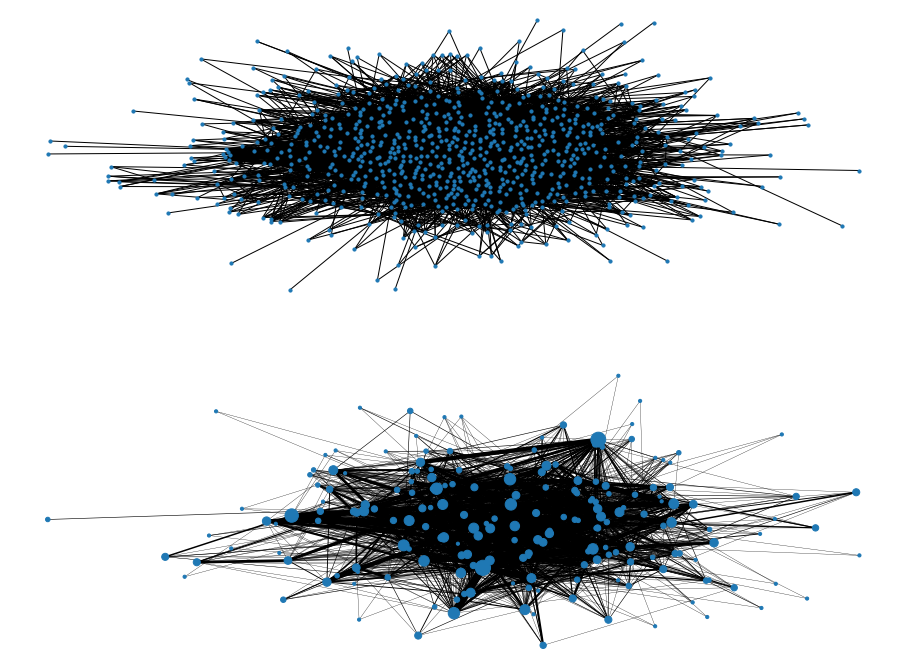

In [22]:
# Extract largest connected component into graph H
H = g2.subgraph(next(nx.connected_components(g2)))

# Makes life easier to have consecutively labeled integer nodes
H = nx.convert_node_labels_to_integers(H)
# Create parititions with hierarchical clustering
partitions = create_hc(H)
# Build blockmodel graph
# 区切り位置ごとに分けるような
BM = nx.quotient_graph(H, partitions, relabel=True)

# Draw original graph
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(H, iterations=100, k=0.2)
plt.subplot(211)
nx.draw(H, pos, with_labels=False, node_size=10)

# Draw block model with weighted edges and nodes sized by number of internal nodes
# 塊の個数によって、大きさをかえる
node_size = [BM.nodes[x]['nnodes'] * 10 for x in BM.nodes()]
edge_width = [(0.3 * d['weight']) for (u, v, d) in BM.edges(data=True)]
# Set positions to mean of positions of internal nodes from original graph
posBM = {}
# 塊の真ん中くらいに描画
for n in BM:
    xy = numpy.array([pos[u] for u in BM.nodes[n]['graph']])
    posBM[n] = xy.mean(axis=0)
plt.subplot(212)
nx.draw(BM, posBM, node_size=node_size, width=edge_width, with_labels=False)
plt.axis('off')
plt.show()

num of community: 3


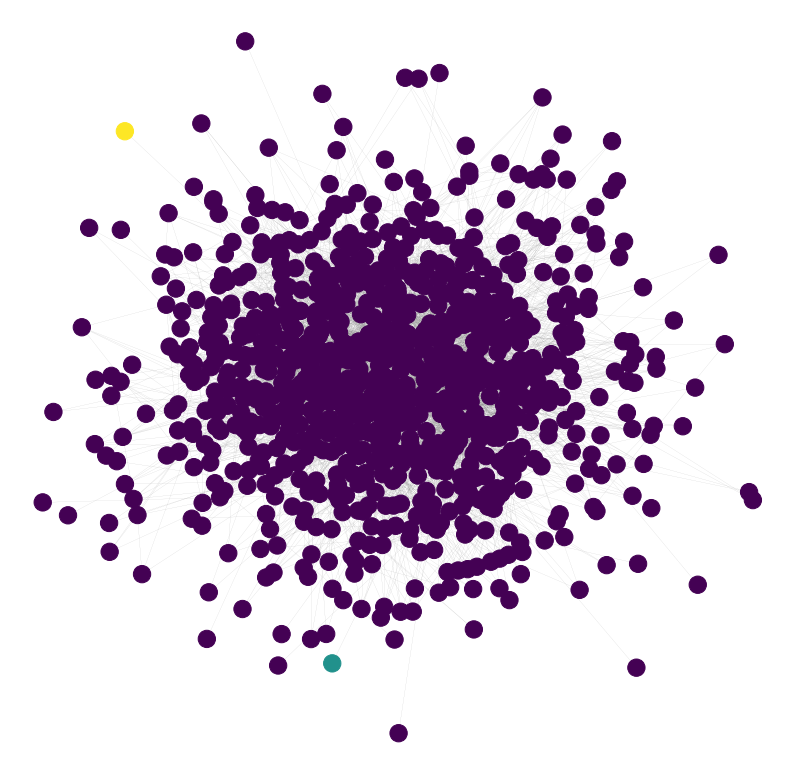

In [23]:
# コミュニティの抽出
# ノード多いと時間かかる
carac = na.get_girvan_newman_com(g2_f[0])
na.draw_network(g2_f[0], df, node_color=carac['val'], draw_label=False)
